In [34]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 12
import pandas as pd
import xarray as xr

import covid19

In [36]:
data_italy_path = 'dpc-covid19-ita-regioni.csv'

data_italy = covid19.data.read_dpc(data_italy_path)

data_italy = data_italy.assign_coords({'location': ('location', [l.partition(' / ')[2] for l in data_italy.location.values])})
data_italy = data_italy.drop(['country', 'lat', 'lon', 'state_region'])
data_italy = xr.merge([data_italy, data_italy.sum('location').expand_dims(location=['Italia'])])
data_italy = data_italy.sortby(data_italy.population)

for col in ['deaths', 'confirmed', 'tests', 'tested']:
    data_italy['daily_' + col] = data_italy[col].diff('time')
    data_italy['daily_' + col + '7'] = data_italy['daily_' + col].rolling({'time': 7}).sum()

data_italy

<xarray.Dataset>
Dimensions:            (location: 22, time: 255)
Coordinates:
  * time               (time) datetime64[ns] 2020-02-24 ... 2020-11-04
  * location           (location) object "Valle d'Aosta" 'Molise' ... 'Italia'
Data variables:
    current_severe     (time, location) float64 0.0 0.0 ... 5.018e+03 2.212e+04
    current_critical   (time, location) float64 0.0 0.0 0.0 ... 507.0 2.292e+03
    deaths             (time, location) float64 0.0 0.0 ... 1.785e+04 3.976e+04
    current_confirmed  (time, location) float64 0.0 0.0 ... 1.047e+05 4.432e+05
    confirmed          (time, location) float64 0.0 0.0 ... 2.242e+05 7.904e+05
    tests              (time, location) float64 7.0 0.0 ... 3.084e+06 1.65e+07
    tested             (time, location) float64 0.0 0.0 ... 1.912e+06 1.002e+07
    population         (location) float64 1.269e+05 3.104e+05 ... 6.059e+07
    daily_deaths       (time, location) float64 nan nan nan ... 34.0 96.0 352.0
    daily_deaths7      (time, location) float64 nan nan nan ... 491.0 1.859e+03
    daily_confirmed    (time, location) float64 nan nan ... 7.758e+03 3.055e+04
    daily_confirmed7   (time, location) float64 nan nan ... 5.366e+04 2.006e+05
    daily_tests        (time, location) float64 nan nan ... 4.372e+04 2.118e+05
    daily_tests7       (time, location) float64 nan nan ... 2.762e+05 1.346e+06
    daily_tested       (time, location) float64 nan nan ... 2.324e+04 1.275e+05
    daily_tested7      (time, location) float64 nan nan ... 1.573e+05 8.234e+05

In [37]:
data_pm_italy = (data_italy / data_italy.population * 1_000_000).drop(['population'])
data_pm_italy['positive_test_rate'] = data_pm_italy['daily_confirmed'] / data_pm_italy['daily_tests']
data_pm_italy['positive_test_rate7'] = data_pm_italy['daily_confirmed7'] / data_pm_italy['daily_tests7']
data_pm_italy

<xarray.Dataset>
Dimensions:              (location: 22, time: 255)
Coordinates:
  * time                 (time) datetime64[ns] 2020-02-24 ... 2020-11-04
  * location             (location) object "Valle d'Aosta" 'Molise' ... 'Italia'
Data variables:
    current_severe       (time, location) float64 0.0 0.0 0.0 ... 500.9 365.0
    current_critical     (time, location) float64 0.0 0.0 0.0 ... 50.6 37.83
    deaths               (time, location) float64 0.0 0.0 ... 1.781e+03 656.3
    current_confirmed    (time, location) float64 0.0 0.0 ... 7.315e+03
    confirmed            (time, location) float64 0.0 0.0 ... 1.304e+04
    tests                (time, location) float64 55.17 0.0 ... 2.723e+05
    tested               (time, location) float64 0.0 0.0 ... 1.654e+05
    daily_deaths         (time, location) float64 nan nan nan ... 9.582 5.81
    daily_deaths7        (time, location) float64 nan nan nan ... 49.01 30.68
    daily_confirmed      (time, location) float64 nan nan nan ... 774.3 504.2
    daily_confirmed7     (time, location) float64 nan nan ... 3.311e+03
    daily_tests          (time, location) float64 nan nan ... 3.496e+03
    daily_tests7         (time, location) float64 nan nan ... 2.221e+04
    daily_tested         (time, location) float64 nan nan ... 2.104e+03
    daily_tested7        (time, location) float64 nan nan ... 1.57e+04 1.359e+04
    positive_test_rate   (time, location) float64 nan nan nan ... 0.1775 0.1442
    positive_test_rate7  (time, location) float64 nan nan nan ... 0.1943 0.1491

In [38]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Alessandro Amici'), bitrate=1800)

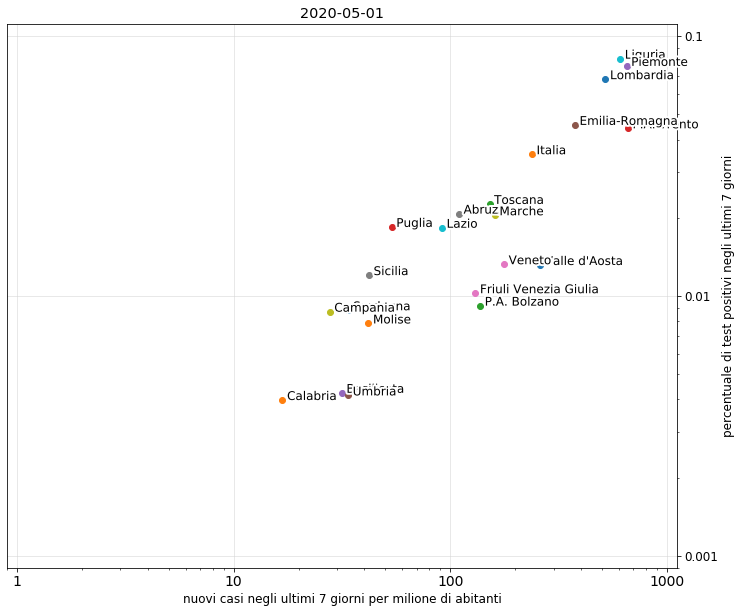

In [39]:
data = data_pm_italy.sel(time=slice('2020-05-01', None))
data['positive_test_rate7'] = xr.where(data['positive_test_rate7'] < 0.001, 0.001, data['positive_test_rate7'])

ani = covid19.plot.animate_scatter(data['daily_confirmed7'], data['positive_test_rate7'], xlim=(0.9, 1000 / 0.9), ylim=(0.0009, 0.10 / 0.9), tail=12, **{
    'xscale': 'log', 'yscale': 'log',
    'xlabel': 'nuovi casi negli ultimi 7 giorni per milione di abitanti', 'ylabel': 'percentuale di test positivi negli ultimi 7 giorni',
})

In [ ]:
# ani.save('covid19-italy.mp4', writer=writer)

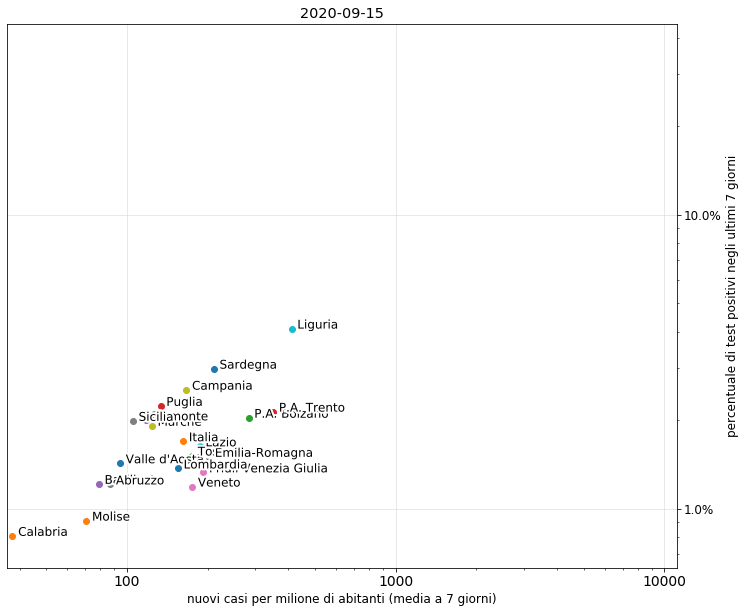

In [44]:
data = data_pm_italy.sel(time=slice('2020-09-15', None))

ani = covid19.plot.animate_scatter(data['daily_confirmed7'], data['positive_test_rate7'], xlim=(40 * 0.9, 10000 / 0.9), ylim=(0.007 * 0.9, 0.40 / 0.9), tail=18, freq='4h', **{
    'xscale': 'log', 'yscale': 'log',
    'xlabel': 'nuovi casi per milione di abitanti (media a 7 giorni)', 'ylabel': 'percentuale di test positivi negli ultimi 7 giorni',
})

In [43]:
ani.save('covid19-italy-small.mp4', writer=writer)

In [ ]:
data = data_pm_italy.sel(time=slice('2020-09-15', None))

ani = covid19.plot.animate_scatter(data['daily_confirmed7'] / 7, data['positive_test_rate7'], xlim=(0, 660), ylim=(0, 0.22), tail=24, freq='4h', **{
    'xscale': 'linear', 'yscale': 'linear',
    'xlabel': 'nuovi casi per milione di abitanti (media a 7 giorni)', 'ylabel': 'percentuale di test positivi negli ultimi 7 giorni',
})

In [ ]:
ani.save('covid19-italy-small-linear.mp4', writer=writer)

In [20]:
lut_path = 'UID_ISO_FIPS_LookUp_Table.csv'
data_world_deaths_path = 'time_series_covid19_deaths_global.csv'
data_world_confirmed_path = 'time_series_covid19_confirmed_global.csv'
data_world = covid19.data.read_jhu_global(data_world_deaths_path, lut_path=lut_path)
data_world['confirmed'] = covid19.data.read_jhu_global(data_world_confirmed_path)['deaths']

data_world = data_world.sortby(data_world.population)

for col in ['deaths', 'confirmed']:
    data_world['daily_' + col] = data_world[col].diff('time')
    data_world['daily_' + col + '7'] = data_world['daily_' + col].rolling({'time': 7}).sum()

data_world

<xarray.Dataset>
Dimensions:           (location: 268, time: 285)
Coordinates:
  * time              (time) datetime64[ns] 2020-01-22 2020-01-23 ... 2020-11-01
    country           (location) <U32 'Holy See' ... 'United Kingdom'
    lat               (location) float64 41.9 43.94 47.14 ... 54.24 16.74 21.69
    lon               (location) float64 12.45 12.46 9.55 ... -62.19 -71.8
  * location          (location) <U46 'Holy See' ... 'United Kingdom / Turks and Caicos Islands'
    state_region      (location) <U46 'Holy See / ' ... 'United Kingdom / Turks and Caicos Islands'
    population        (location) float64 809.0 3.394e+04 3.814e+04 ... nan nan
Data variables:
    deaths            (time, location) int64 0 0 0 0 0 0 0 0 ... 1 48 0 0 24 1 6
    confirmed         (time, location) int64 0 0 0 0 0 0 ... 13 703 353 13 704
    daily_deaths      (time, location) float64 nan nan nan nan ... 0.0 0.0 0.0
    daily_deaths7     (time, location) float64 nan nan nan nan ... 0.0 0.0 0.0
    daily_confirmed   (time, location) float64 nan nan nan nan ... 0.0 0.0 1.0
    daily_confirmed7  (time, location) float64 nan nan nan nan ... 5.0 0.0 3.0

In [21]:
data_pm_world = (data_world / data_world.population * 1_000_000).drop(['population'])
data_pm_world

<xarray.Dataset>
Dimensions:           (location: 268, time: 285)
Coordinates:
    lon               (location) float64 12.45 12.46 9.55 ... -62.19 -71.8
    lat               (location) float64 41.9 43.94 47.14 ... 54.24 16.74 21.69
  * location          (location) <U46 'Holy See' ... 'United Kingdom / Turks and Caicos Islands'
    country           (location) <U32 'Holy See' ... 'United Kingdom'
  * time              (time) datetime64[ns] 2020-01-22 2020-01-23 ... 2020-11-01
    state_region      (location) <U46 'Holy See / ' ... 'United Kingdom / Turks and Caicos Islands'
Data variables:
    deaths            (time, location) float64 0.0 0.0 0.0 0.0 ... nan nan nan
    confirmed         (time, location) float64 0.0 0.0 0.0 0.0 ... nan nan nan
    daily_deaths      (time, location) float64 nan nan nan nan ... nan nan nan
    daily_deaths7     (time, location) float64 nan nan nan nan ... nan nan nan
    daily_confirmed   (time, location) float64 nan nan nan nan ... nan nan nan
    daily_confirmed7  (time, location) float64 nan nan nan nan ... nan nan nan

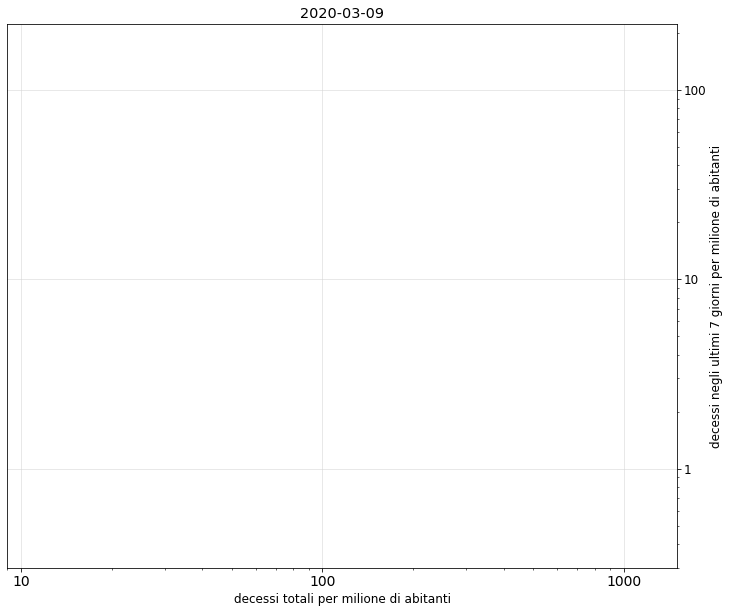

In [22]:
data = data_pm_world.sel(time=slice('2020-03-09', None), location=data_world['deaths'].isel(time=-1) > 1000)
data['daily_deaths7'] = xr.where(data['daily_deaths7'] < 0.31, 0.31, data['daily_deaths7'])

ani = covid19.plot.animate_scatter(data['deaths'], data['daily_deaths7'], xlim=(9, 1500), ylim=(0.3, 200 / 0.9), **{
    'xscale': 'log', 'yscale': 'log',
    'xlabel': 'decessi totali per milione di abitanti', 'ylabel': 'decessi negli ultimi 7 giorni per milione di abitanti',
})

In [11]:
ani.save('covid19-world.mp4', writer=writer)

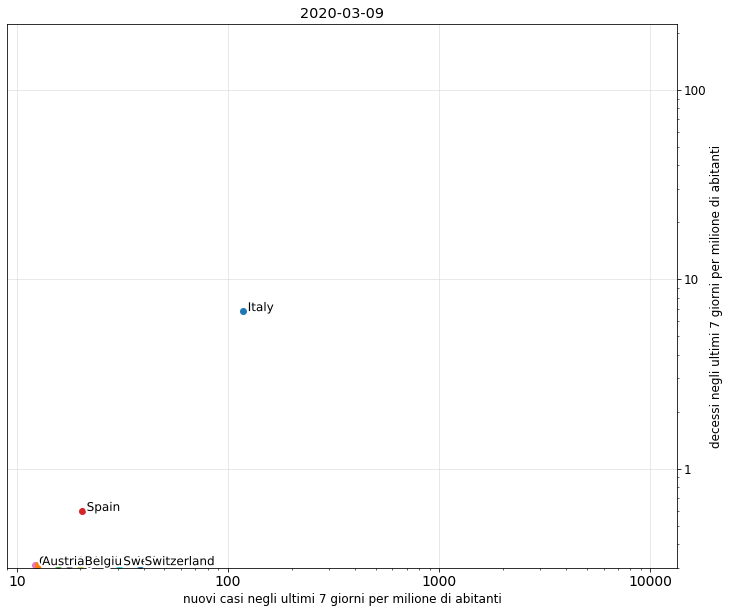

In [32]:
data = data_pm_world.sel(time=slice('2020-03-09', None), location=data_world['deaths'].isel(time=-1) > 1000)
data = data.sel(location=['Italy', 'Israel', 'France', 'Spain', 'United Kingdom', 'US', 'Germany', 'Netherlands', 'Belgium', 'Sweden', 'Switzerland', 'Austria'])
data['daily_deaths7'] = xr.where(data['daily_deaths7'] < 0.31, 0.31, data['daily_deaths7'])

ani = covid19.plot.animate_scatter(data['daily_confirmed7'], data['daily_deaths7'], xlim=(9, 12000 / 0.9), ylim=(0.3, 200 / 0.9), tail=12, **{
    'xscale': 'log', 'yscale': 'log',
    'xlabel': 'nuovi casi negli ultimi 7 giorni per milione di abitanti', 'ylabel': 'decessi negli ultimi 7 giorni per milione di abitanti',
})

In [33]:
ani.save('covid19-world2.mp4', writer=writer)